In [1]:
import cutiepy
cutiepy.interactive.INTERACTIVE = False
cutiepy.operators.SPARSITY_N_CUTOFF = 1000

import qutip
qutip_rhs_reuse = True

import numpy as np
import scipy
%matplotlib inline
import matplotlib.pyplot as plt

n_small_cutoffs = list(range(  2,  10     ))
n_med_cutoffs   = list(range( 10, 100,  10))
n_big_cutoffs   = list(range(100, 600, 100))
ns = [n_small_cutoffs, n_med_cutoffs, n_big_cutoffs]
periods = [100, 10, 1]

def cutiepy_sym_state(n):
    return cutiepy.Ket.anon([n], np.ones((n,1), dtype=complex)/n**0.5)

def qutip_sym_state(n):
    return qutip.Qobj(np.ones((n,1), dtype=complex)/n**0.5)

from timeit import repeat

setup = '''
import cutiepy
cutiepy.interactive.INTERACTIVE = False
cutiepy.operators.SPARSITY_N_CUTOFF = 1000

import qutip
qutip_rhs_reuse = True

import numpy as np
import scipy

def cutiepy_sym_state(n):
    return cutiepy.Ket.anon([n], np.ones((n,1), dtype=complex)/n**0.5)
def qutip_sym_state(n):
    return qutip.Qobj(np.ones((n,1), dtype=complex)/n**0.5)
'''

def parametric_timeit(ex_, setup_, params):
    res = []
    for _ns, _p in zip(ns, params):
        _res = []
        for _n in _ns:
            print('\r p=%d, n=%d'%(_p,_n), end='', flush=True)
            _r = repeat(ex_, setup+setup_.format(param=_p, N_cutoff=_n),repeat=5,number=1)
            _res.append(_r)
        res.append(_res)
    print('\r Done!')
    return res

def plot_times(datas, labels):
    datas = [[np.array([sorted(_runs) for _runs in _vsn]) for _vsn in data]
             for data in datas]
    plt.figure(figsize=(14,3))
    for data in datas:
        plt.subplot(1,3,1)
        plt.plot(n_small_cutoffs, data[0][:,0], 'o')
        plt.subplot(1,3,2)
        plt.plot(n_med_cutoffs, data[1][:,0], 'o')
        plt.subplot(1,3,3)
        plt.plot(n_big_cutoffs, data[2][:,0], 'o')
    plt.subplot(1,3,1)
    plt.ylabel('seconds')
    plt.xlabel('problem dimension')
    plt.title('%d periods'%periods[0])
    plt.subplot(1,3,2)
    plt.title('%d periods'%periods[1])
    plt.subplot(1,3,3)
    plt.legend(labels, loc=2)
    plt.title('%d period'%periods[2])

# Time independent

In [3]:
setup_q = '''
ts = np.linspace(0,{param}*np.pi,{param}*10)
init = qutip_sym_state({N_cutoff})
H = qutip.num({N_cutoff})
opt = qutip.Options(rhs_reuse=qutip_rhs_reuse, nsteps=1000*{N_cutoff})
'''
ex_q = '''
res = qutip.sesolve(H,init,ts,[], options=opt)
'''

HARM_OSC_SYM_STATE_qutip = parametric_timeit(ex_q, setup_q, periods)

 Done!


In [16]:
setup_c = '''
ts = np.linspace(0,{param}*np.pi,{param}*10)
init = cutiepy_sym_state({N_cutoff})
H = cutiepy.num({N_cutoff})
mxsteps = 1000*{N_cutoff}
'''
ex_c = '''
res = cutiepy.sesolve(H,init,ts, mxsteps=mxsteps)
'''

HARM_OSC_SYM_STATE_cutiepy = parametric_timeit(ex_c, setup_c, periods)

 Done!


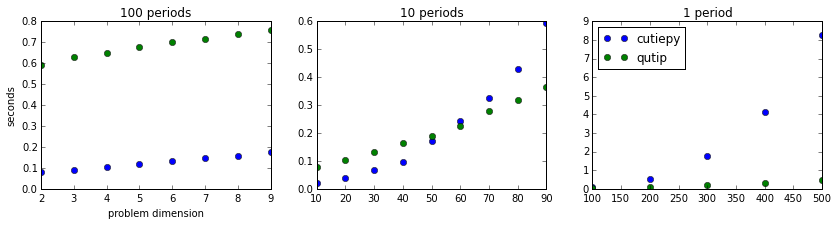

In [26]:
plot_times([HARM_OSC_SYM_STATE_cutiepy, HARM_OSC_SYM_STATE_qutip], ['cutiepy', 'qutip'])

# Time dependent

In [42]:
setup_q = '''
ts = np.linspace(0,{param}*np.pi/10,{param}*10)
init = qutip_sym_state({N_cutoff})
H0 = qutip.zero_oper({N_cutoff})
H = qutip.num({N_cutoff})
tdep = 't/({param}*np.pi)'
opt = qutip.Options(rhs_reuse=qutip_rhs_reuse, nsteps=1000*{N_cutoff})
'''
ex_q = '''
res = qutip.mesolve([H0,[H,tdep]],init,ts,[],[], options=opt)
'''

HARM_OSC_RAMP_SYM_STATE_qutip = parametric_timeit(ex_q, setup_q, periods)

 Done!


In [45]:
setup_c = '''
ts = np.linspace(0,{param}*np.pi/10,{param}*10)
init = cutiepy_sym_state({N_cutoff})
H = cutiepy.num({N_cutoff})*cutiepy.t/({param}*np.pi)
mxsteps = 1000*{N_cutoff}
'''
ex_c = '''
res = cutiepy.mesolve(H,[],init,ts, mxsteps=mxsteps)
'''

HARM_OSC_RAMP_SYM_STATE_cutiepy = parametric_timeit(ex_c, setup_c, periods)

 Done!


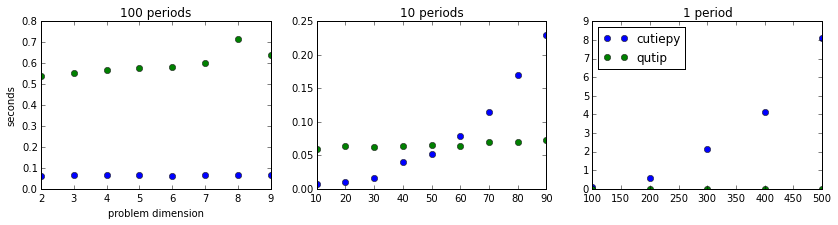

In [46]:
plot_times([HARM_OSC_RAMP_SYM_STATE_cutiepy, HARM_OSC_RAMP_SYM_STATE_qutip], ['cutiepy', 'qutip'])